In [1]:
from pyulog import ULog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

In [2]:
ulog = ULog("flight_data.ulg")
for d in ulog.data_list:
    if d.name == "vehicle_attitude":
        print(f"{d.name} --> {list(d.data.keys())}") 

vehicle_attitude --> ['timestamp', 'timestamp_sample', 'q[0]', 'q[1]', 'q[2]', 'q[3]', 'delta_q_reset[0]', 'delta_q_reset[1]', 'delta_q_reset[2]', 'delta_q_reset[3]', 'quat_reset_counter']


In [3]:
def get_topic(name):
    return max((d for d in ulog.data_list if d.name == name), key = lambda x: len(x.data.keys()))

In [4]:
# SENSOR COMBINED
sensor_combined = get_topic("sensor_combined")
df_sensor = pd.DataFrame(sensor_combined.data)
df_sensor = df_sensor[[
    "timestamp", 
    "gyro_rad[0]", "gyro_rad[1]", "gyro_rad[2]",
    "accelerometer_m_s2[0]", "accelerometer_m_s2[1]", "accelerometer_m_s2[2]",
    "gyro_integral_dt", "accelerometer_integral_dt",
    "gyro_clipping", "accelerometer_clipping"
]]

# VEHICLE ATTITUDE (quaternion to Euler)
vehicle_attitude = get_topic("vehicle_attitude")
df_att = pd.DataFrame(vehicle_attitude.data)

def quaternion_to_euler(df):
    q0, q1, q2, q3 = df['q[0]'], df['q[1]'], df['q[2]'], df['q[3]']
    roll = np.arctan2(2*(q0*q1 + q2*q3), 1 - 2*(q1**2 + q2**2))
    pitch = np.arcsin(np.clip(2*(q0*q2 - q3*q1), -1, 1))
    yaw = np.arctan2(2*(q0*q3 + q1*q2), 1 - 2*(q2**2 + q3**2))
    return roll, pitch, yaw
df_att["roll"], df_att["pitch"], df_att["yaw"] = quaternion_to_euler(df_att)
df_att = df_att[["timestamp", "roll", "pitch", "yaw"]]

# VEHICLE ATTITUDE SETPOINT
att_setpoint = get_topic("vehicle_attitude_setpoint")
df_att_sp = pd.DataFrame(att_setpoint.data)
df_att_sp = df_att_sp[["timestamp", "roll_body", "pitch_body", "yaw_body"]]

# ACTUATOR OUTPUTS
actuator_outputs = get_topic("actuator_outputs")
df_act = pd.DataFrame(actuator_outputs.data)
df_act = df_act[["timestamp", "output[0]", "output[1]", "output[2]"]]

# BATTERY STATUS
battery_status = get_topic("battery_status")
df_batt = pd.DataFrame(battery_status.data)
df_batt = df_batt[["timestamp", "voltage_v", "current_a"]]

# VEHICLE GLOBAL POSITION
gps = get_topic("vehicle_global_position")
df_gps = pd.DataFrame(gps.data)
df_gps = df_gps[["timestamp", "lat", "lon", "alt"]]

# RATE CTRL STATUS
rate_ctrl = get_topic("rate_ctrl_status")
df_rate = pd.DataFrame(rate_ctrl.data)
df_rate = df_rate[["timestamp", "rollspeed_integ", "pitchspeed_integ", "yawspeed_integ"]]


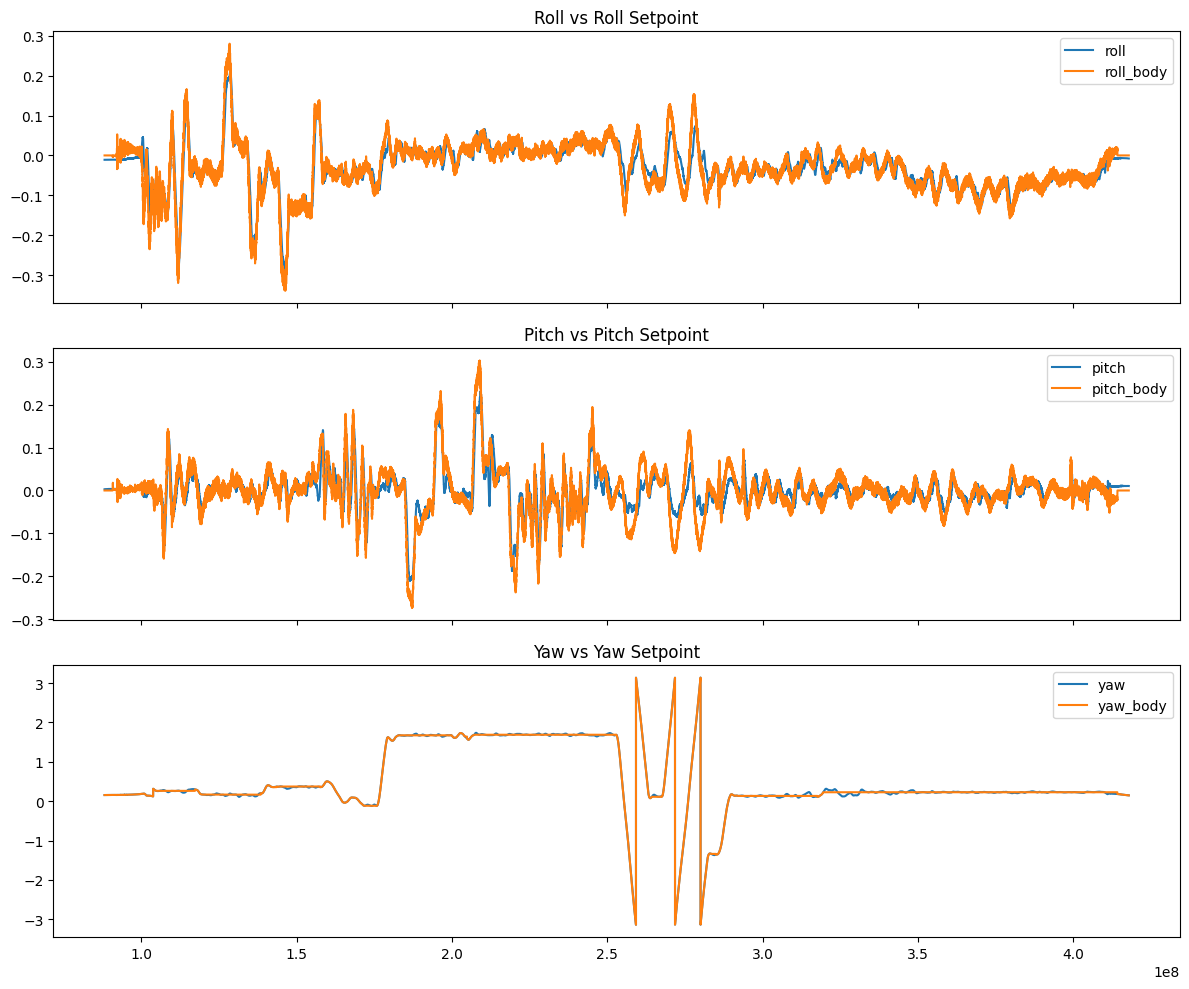

In [5]:
df_att.sort_values("timestamp", inplace=True)
df_att_sp.sort_values("timestamp", inplace=True)

df_compare = pd.merge_asof(
    df_att[['timestamp', 'roll', 'pitch', 'yaw']],
    df_att_sp[['timestamp', 'roll_body', 'pitch_body', 'yaw_body']],
    on='timestamp',
    direction='nearest',
    tolerance=1_000_000
)

df_compare.dropna(inplace=True)

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
axs[0].plot(df_compare['timestamp'], df_compare['roll'], label='roll')
axs[0].plot(df_compare['timestamp'], df_compare['roll_body'], label='roll_body')
axs[0].set_title("Roll vs Roll Setpoint")
axs[0].legend()

axs[1].plot(df_compare['timestamp'], df_compare['pitch'], label='pitch')
axs[1].plot(df_compare['timestamp'], df_compare['pitch_body'], label='pitch_body')
axs[1].set_title("Pitch vs Pitch Setpoint")
axs[1].legend()

axs[2].plot(df_compare['timestamp'], df_compare['yaw'], label='yaw')
axs[2].plot(df_compare['timestamp'], df_compare['yaw_body'], label='yaw_body')
axs[2].set_title("Yaw vs Yaw Setpoint")
axs[2].legend()

plt.tight_layout()
plt.show()

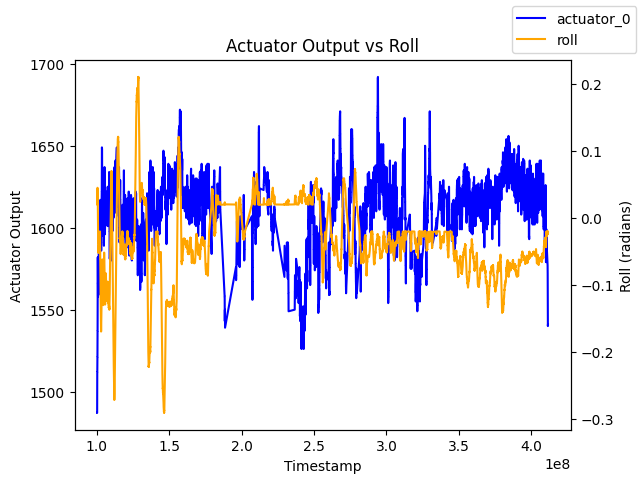

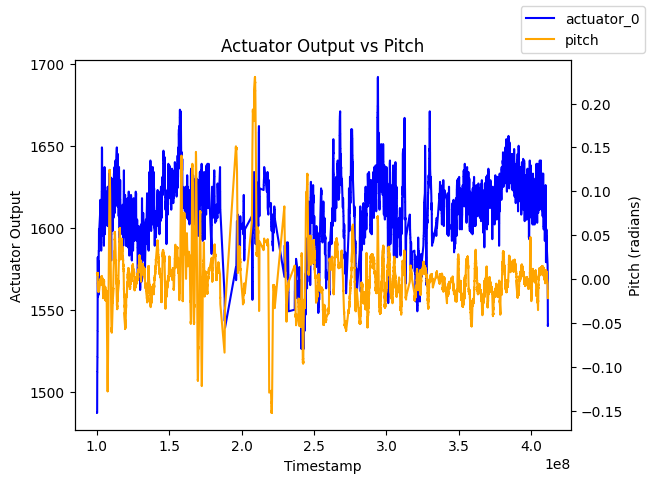

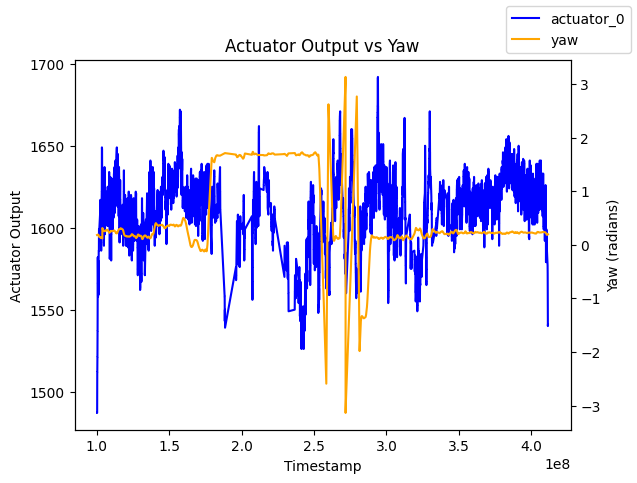

In [6]:
df_act.sort_values("timestamp", inplace=True)

df_att_trimmed = df_att[['timestamp', 'roll', 'pitch', 'yaw']]
df_act_trimmed = df_act[['timestamp', 'output[0]', 'output[1]', 'output[2]']]  # example outputs
df_att_trimmed = df_att_trimmed[df_att_trimmed['roll'].abs() > 0.02]

df_merge_act = pd.merge_asof(
    df_att_trimmed,
    df_act_trimmed,
    on='timestamp',
    direction='nearest',
    tolerance=1_000_000
)

df_merge_act.dropna(inplace=True)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_merge_act['timestamp'], df_merge_act['output[0]'], color='blue', label='actuator_0')
ax2.plot(df_merge_act['timestamp'], df_merge_act['roll'], color='orange', label='roll')
ax1.set_ylabel('Actuator Output')
ax2.set_ylabel('Roll (radians)')
ax1.set_xlabel('Timestamp')
plt.title('Actuator Output vs Roll')
fig.legend(loc="upper right")
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_merge_act['timestamp'], df_merge_act['output[0]'], color='blue', label='actuator_0')
ax2.plot(df_merge_act['timestamp'], df_merge_act['pitch'], color='orange', label='pitch')
ax1.set_ylabel('Actuator Output')
ax2.set_ylabel('Pitch (radians)')
ax1.set_xlabel('Timestamp')
plt.title('Actuator Output vs Pitch')
fig.legend(loc="upper right")
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(df_merge_act['timestamp'], df_merge_act['output[0]'], color='blue', label='actuator_0')
ax2.plot(df_merge_act['timestamp'], df_merge_act['yaw'], color='orange', label='yaw')
ax1.set_ylabel('Actuator Output')
ax2.set_ylabel('Yaw (radians)')
ax1.set_xlabel('Timestamp')
plt.title('Actuator Output vs Yaw')
fig.legend(loc="upper right")
plt.show()

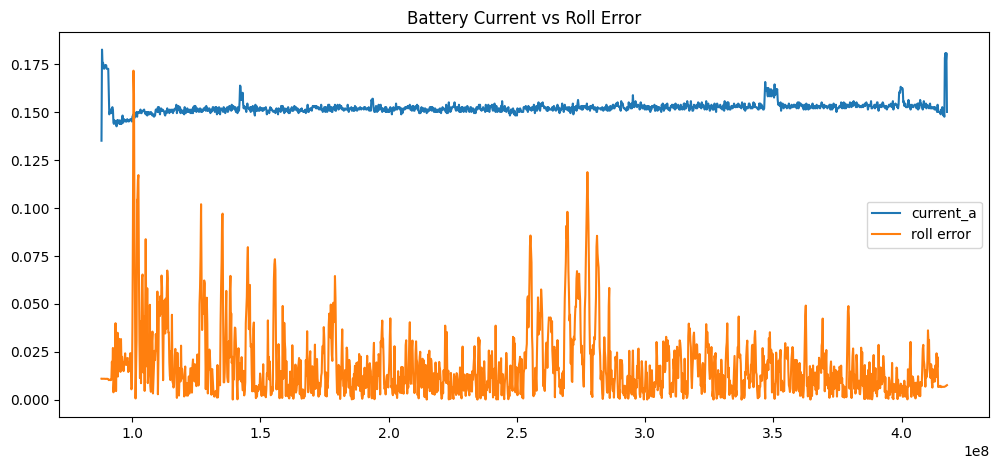

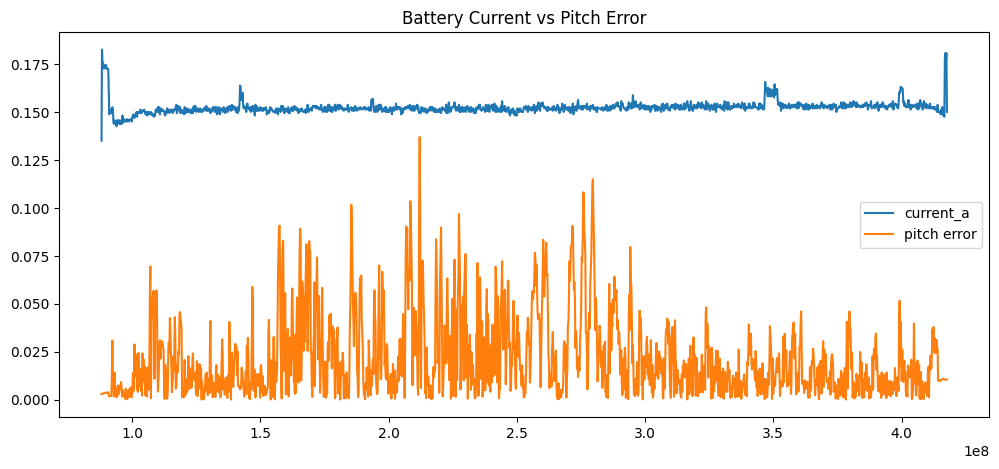

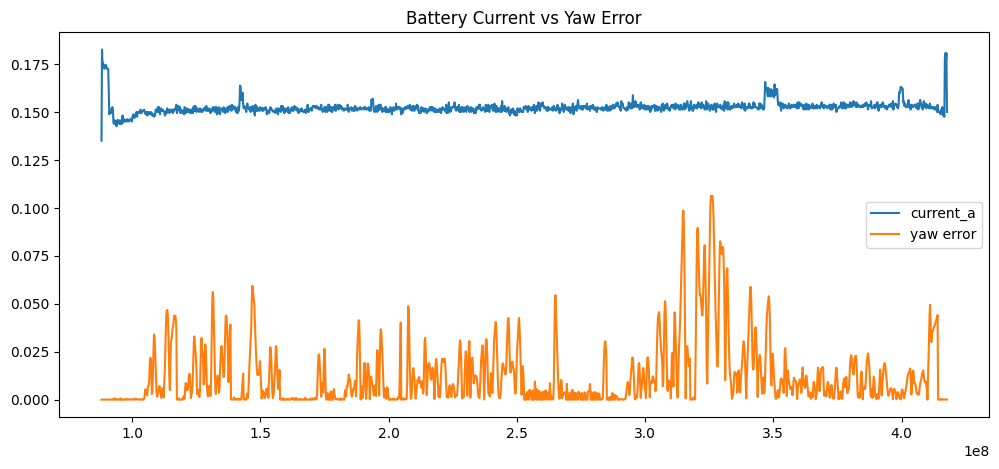

In [7]:
df_compare['roll_err'] = abs(df_compare['roll'] - df_compare['roll_body'])
df_compare['pitch_err'] = abs(df_compare['pitch'] - df_compare['pitch_body'])
df_compare['yaw_err'] = abs(df_compare['yaw'] - df_compare['yaw_body'])

df_batt.sort_values("timestamp", inplace=True)

df_compare_battery = pd.merge_asof(
    df_batt[['timestamp', 'current_a']],
    df_compare[['timestamp', 'roll_err', 'pitch_err', 'yaw_err']],
    on='timestamp',
    direction='nearest',
    tolerance=1_000_000
)

df_compare_battery.dropna(inplace=True)

plt.figure(figsize=(12, 5))
plt.plot(df_compare_battery['timestamp'], df_compare_battery['current_a'], label='current_a')
plt.plot(df_compare_battery['timestamp'], df_compare_battery['roll_err'], label='roll error')
plt.title("Battery Current vs Roll Error")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_compare_battery['timestamp'], df_compare_battery['current_a'], label='current_a')
plt.plot(df_compare_battery['timestamp'], df_compare_battery['pitch_err'], label='pitch error')
plt.title("Battery Current vs Pitch Error")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(df_compare_battery['timestamp'], df_compare_battery['current_a'], label='current_a')
plt.plot(df_compare_battery['timestamp'], df_compare_battery['yaw_err'], label='yaw error')
plt.title("Battery Current vs Yaw Error")
plt.legend()
plt.show()

In [8]:
for df in [df_att, df_att_sp, df_act, df_batt, df_sensor, df_rate, df_gps]:
    df.sort_values('timestamp', inplace=True)

df_merged = pd.merge_asof(df_att, df_att_sp, on='timestamp')
df_merged = pd.merge_asof(df_merged, df_act, on='timestamp')
df_merged = pd.merge_asof(df_merged, df_batt, on='timestamp')
df_merged = pd.merge_asof(df_merged, df_sensor, on='timestamp')
df_merged = pd.merge_asof(df_merged, df_rate, on='timestamp')
df_merged = pd.merge_asof(df_merged, df_gps, on='timestamp')


In [9]:
print(df_merged.columns)

Index(['timestamp', 'roll', 'pitch', 'yaw', 'roll_body', 'pitch_body',
       'yaw_body', 'output[0]', 'output[1]', 'output[2]', 'voltage_v',
       'current_a', 'gyro_rad[0]', 'gyro_rad[1]', 'gyro_rad[2]',
       'accelerometer_m_s2[0]', 'accelerometer_m_s2[1]',
       'accelerometer_m_s2[2]', 'gyro_integral_dt',
       'accelerometer_integral_dt', 'gyro_clipping', 'accelerometer_clipping',
       'rollspeed_integ', 'pitchspeed_integ', 'yawspeed_integ', 'lat', 'lon',
       'alt'],
      dtype='object')


In [10]:
df_merged["roll_error"]  = df_merged["roll_body"]  - df_merged["roll"]
df_merged["pitch_error"] = df_merged["pitch_body"] - df_merged["pitch"]
df_merged["yaw_error"]   = df_merged["yaw_body"]   - df_merged["yaw"]

In [11]:
df_merged["actuator_total"] = df_merged[["output[0]", "output[1]", "output[2]"]].sum(axis=1)

In [12]:
df_merged["gyro_mag"] = np.sqrt(df_merged["gyro_rad[0]"]**2 + df_merged["gyro_rad[1]"]**2 + df_merged["gyro_rad[2]"]**2)
df_merged["accel_mag"] = np.sqrt(df_merged["accelerometer_m_s2[0]"]**2 + df_merged["accelerometer_m_s2[1]"]**2 + df_merged["accelerometer_m_s2[2]"]**2)

In [13]:
df_merged["gyro_clipped"] =df_merged["gyro_clipping"] > 0
df_merged["accel_clipped"] = df_merged["accelerometer_clipping"] > 0

In [14]:
df_merged["current_per_output"] = df_merged["current_a"] / (df_merged["actuator_total"] + 1e-6)

In [15]:
df_merged["lat_norm"] = df_merged["lat"] - df_merged["lat"].min()
df_merged["lon_norm"] = df_merged["lon"] - df_merged["lon"].min()

In [23]:
df_merged.dropna(inplace=True)

iso_features = ["roll_error", "pitch_error", "yaw_error",
    "current_a", "voltage_v",
    "actuator_total",
    "current_per_output"]
ae_features = ['roll', 'pitch', 'yaw',
    'roll_error', 'pitch_error', 'yaw_error',
    'actuator_total', 'current_per_output',
    'gyro_mag', 'accel_mag',
    'rollspeed_integ', 'pitchspeed_integ', 'yawspeed_integ',
    'voltage_v', 'current_a']

iso_scaler = StandardScaler()
ae_scaler = StandardScaler()

iso_scaler.fit(df_merged[iso_features])
ae_scaler.fit(df_merged[ae_features])
joblib.dump(iso_scaler, "iso_scaler.pkl")
joblib.dump(ae_scaler, "ae_scaler.pkl")
joblib.dump(iso_features, "iso_features.pkl")
joblib.dump(ae_features, "ae_features.pkl")

['ae_features.pkl']